# Utilizing Cyclostationary Signal Processing Techniques. 
## Techniques used
1. Cyclic Autocorrelation Function (CAF)
2. Spectral Correlation Function (SCF)


## Can you accomplish the following...
1. Detect different modulation schemes?
    1. {2, 4, 8}-PSK, {16, 32, 64}-QPSK 
2. Detect the number of unique symbols sent?
3. Detect the length of the repeated symbols?
4. Is this detection sensitive to AWGN?



## Simplifications

1. No pulse shaping filter is used... Instead a simple repeated symbol scheme is used. 
    1. (**Not tested**) Justification... As long as the pulse shaping function that is utilized is a linearly time invariant filter, then the signals periodic properties are still intact. This should translate to similar results while speeding up computation as you can potentially target specific frequency bins.
    
    1. (**Support**) if $S(t)$ is periodic with period $T$,  $S(t) = S(t+k T) \quad k \in \mathbf{Z}$ and let $h$ be a LTI filter... $ h(t_1) = h(t_2) \quad \forall t_1,t_2 \in \mathbf{R}$, with, 
    the convolution denoted as $\circledast$  

 $$ \qquad
        (S \circledast h)(t) = \int_{-\infty}^{\infty}S(t)h(t-\tau) d{\tau}            \equiv  \qquad
        (S \circledast h)(t+kT) = \int_{-\infty}^{\infty}S(t+kT)h(t+kT-\tau) d{\tau}   
 $$
 
 By $h$ being LTI, and $S(t)$ having period $T$

# Simulated Data

In [1]:
# Imports
%matplotlib notebook 
# optional # %matplotlib inline
import numpy as np
from commpy import PSKModem, QAMModem
from commpy.filters import rectfilter, gaussianfilter, rrcosfilter, rcosfilter
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks
import pandas as pd
import scipy.stats as st
from scipy import signal
import seaborn as sns
from sklearn import mixture


In [2]:
## Helper functions
def get_iq(df_s):
    """
    transform a df series of complex vals
    into the dataFrame of real and imaginary columns.
    Return: pandas.DataFrame
    """    
    dfc = {
        "i": (df_s.values).real,
        "q": (df_s.values).imag
    }
    
    return pd.DataFrame(dfc)

def detect_freq_range(z, alpha=0.95):
    """
    View lagged correlation of signal to determine
    a frequency responce and filter out the decaying harmonics...
    Input: z_t complex time signal.
    
    """    
    auto_cor = signal.correlate(z,
                       z,
                       mode="same")/len(z)
    
    lags = signal.correlation_lags(z.size, z.size, mode="same")
    
    a_cor = auto_cor[lags]

    asym_scf = np.fft.fftshift(np.fft.fft(auto_cor))
    
    
    y = np.log(np.abs(asym_scf))
    peaks_caf =  find_peaks(y)[0]
    
    #create alpha% confidence interval for population mean weight
    lb, ub = st.t.interval(alpha=alpha,
                  df=len(peaks_caf)-1,
                  loc=np.mean(peaks_caf),
                  scale=st.sem(peaks_caf)) 
    p_indexs = np.r_[int(np.floor(lb)):int(np.ceil(ub))]
    p_tones = np.zeros(asym_scf.size, dtype=np.complex64)
    
    p_tones[p_indexs] = np.fft.ifft(np.fft.fft(auto_cor)[p_indexs])
    
    
    return lb, ub, p_indexs, p_tones


def pplot(df_s, df):
    """
    df_s is a dataframe series containing complex values for a scatter plot
    df is the full data frame so I can access the noise levels for coloring
    """
    df_iq = get_iq(df_s)
    color_ = 1 - np.abs(df["noise_vec"])/np.max(np.abs(df["noise_vec"]))
    df_iq["complement_noise_lvl"] = color_
    plt.close("all")
    df_iq.plot.scatter(x="i", y="q",c="complement_noise_lvl", colormap='viridis', alpha=color_ )
    plt.title(df_s.name)
    plt.show()

In [3]:
#
# Set up the paramaters
##
nsymbols=2
repeats_per_symbol = 16 # less than 16
samples_per_second = 1e3
message_len = 3*2*16
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 1  # fc center frequency 
noise_sd = 0.50 # noise 


nbits = np.ceil(np.log2(nsymbols))
sym_per_sec = samples_per_second/repeats_per_symbol

bit_rate = nbits*sym_per_sec



# calculate
duration = total_samples/samples_per_second
time = np.linspace(0, duration, total_samples)  # clock time of each sample
dt = duration/(total_samples)
freqs = np.fft.ifftshift(np.fft.fftfreq(len(time), dt))

## apply pulse shaping filter

### ---------------------- Hamming Filter  -----------------------------------

# h_filter = np.hamming(repeats_per_symbol)  # no idea if this is the right thing to convolve!
# h_filter  = h_filter/np.sum(h_filter)

### ---------------------- Rectangular pulse -----------------------------------

N   =   repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   1/dt             #(float) – Sampling Rate in Hz.
print(N,Ts,Fs)

time_index, h_filter = rectfilter(N, Ts, Fs)




print(f" Set Fs: {1/dt} \n Set dt: {dt} \n Total_Samples: {len(time)}")

params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs,
    "h_filter": h_filter
    }

16 62.5 1000.0
 Set Fs: 1000.0 
 Set dt: 0.001 
 Total_Samples: 1536


In [4]:
# Definition to get test data
def gen_df(params={}):
    print("generating df... ")
    # set params
    nsymbols =  params["nsymbols"]
    repeats_per_symbol = params["repeats_per_symbol"]
    samples_per_second = params["samples_per_second"]
    message_len = params["message_len"]
    total_samples = params["total_samples"]
    baseband_carrier_freq = params["baseband_carrier_freq"]
    noise_sd = params["noise_sd"]
    duration = params["duration"]
    time =  params["time"]
    dt = params["dt"]
    freqs = params["freqs"]
    h_filter = params["h_filter"]
    
    # define values...     
    baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)
    baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)
     # define constellation
    #### ___________________________________________________############
    ## m = QAMModem(nsymbols)
    m = PSKModem(nsymbols) # Want to test BPSK
    
    con = m.constellation
    con = con/np.max(np.abs(con))  # power normablizing
    
    # set message
    symbol_message = np.random.randint(0, nsymbols, message_len)
    message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
    
    # Pulse shapeing with hamming filter
    # better repeat scheme
    #
    pad_message = np.zeros(len(symbol_message)*repeats_per_symbol, dtype=complex)
    indexes = np.arange(len(symbol_message))*repeats_per_symbol
    pad_message[indexes] = con[symbol_message]
    

    # print(np.sum(hamming_filter))
    
    # Note I didnt use the pad message here instead I convolved the iq_encoded message  I was curious what the difference in the spectrogram would be
    smooth_iq_encoded_message = signal.fftconvolve(pad_message, h_filter, mode="same")
    
    # An IQ encoding of a message is just a symbol lookup table
    iq_encoded_message = con[message_with_repeats]
    
    # Modulate the encoding unto the baseband cf
    modulated = iq_encoded_message*baseband_signal
    smooth_modulated = smooth_iq_encoded_message*baseband_signal
    
    # AWGN 
    noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) + \
        1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
    
    
    # Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
    channel_iq = modulated + noise
    smooth_channel_iq = smooth_modulated + noise
    
    # Unmodulate with baseband inv to get the original modulation with noise effects
    unmodulated = channel_iq*baseband_inv
    smooth_unmodulated = smooth_channel_iq*baseband_inv
    
    data = {
        "modulated": modulated,
        "unmodulated":unmodulated,
        "channel_iq": channel_iq,
        "iq_encoded_message": iq_encoded_message,
        "baseband_signal": baseband_signal,
        "baseband_inv": baseband_inv,
        "noise_vec":noise,
        "smooth_channel_iq": smooth_channel_iq,
        "smooth_modulated": smooth_modulated,
        "smooth_iq_encoded_message": smooth_iq_encoded_message,
        "smooth_unmodulated": smooth_unmodulated
        }
    
    df = pd.DataFrame(data)
    return params, df
    
    
params, df = gen_df(params=params)  

print("columns", [col for col in df.columns.values])
# optional prints... 

# print(df.describe())
# print(df.info())

generating df... 
columns ['modulated', 'unmodulated', 'channel_iq', 'iq_encoded_message', 'baseband_signal', 'baseband_inv', 'noise_vec', 'smooth_channel_iq', 'smooth_modulated', 'smooth_iq_encoded_message', 'smooth_unmodulated']


<IPython.core.display.Javascript object>


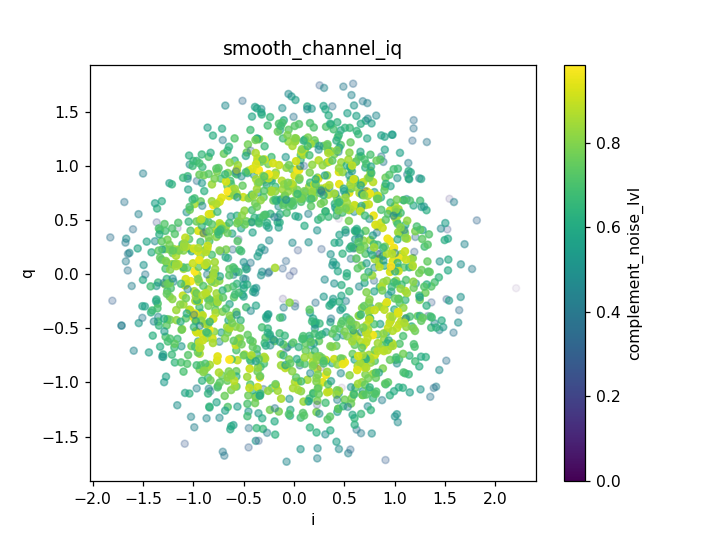

In [5]:
# defint input data... and plot iq 


# select = 'channel_iq'
# select = "modulated"
select = 'smooth_channel_iq'
# select = 'smooth_unmodulated'
# select = "unmodulated"
# select = 'iq_encoded_message'


x = np.asarray(df[select])  

pplot(df[select], df)


# Estimate a low bias PSD via frequency smoothing method (FSM)
following Chad Spooner's blog post to write a biased estimator of the PSD.

https://cyclostationary.blog/2015/11/20/csp-estimators-the-frequency-smoothing-method/

Estimate the following feature values.
1. The Periodogram (p_0)
2. The Cyclic Periodogram (cp_0)
3. The Conjugate Cyclic Periodogram (c_cp_0)
4. The Frequency Smoothed Periodogram (fsp) ... is approximately equal to the PSD.
5. The Frequency Smoothed Cyclic Periodogram (fscp) ... is approximately equal to the SCF. 
6. The Frequency Smoothed Conjugate Cyclic Periodogram (c_fscp) ... is approximately equal to the C_SCF. 


In [6]:
# 1. The Periodogram (p_0)
def p_0(z_t):
    """
    input is a complex valued discrete time signal
    output is The periodogram
    """
    N = len(z_t)
    Z_f = np.fft.fftshift(np.fft.fft(z_t))
    ab_s =  np.abs(Z_f)
    I_f = ab_s*ab_s/N
    return I_f

I_f = p_0(x)

print(f"carrier_freq estimate: {freqs[np.argmax(I_f)]}")

'''
# Graph
plt.close("all")
plt.plot(freqs,  I_f, linewidth=0.2, marker = '.', alpha=0.3)
plt.show()

'''





carrier_freq estimate: 20.833333333333332


'\n# Graph\nplt.close("all")\nplt.plot(freqs,  I_f, linewidth=0.2, marker = \'.\', alpha=0.3)\nplt.show()\n\n'

In [117]:
#2. The Cyclic Periodogram (cp_0)
def cp_0(z_t, alpha_vec, freqs, fbin=3*80):
    """
    return df columns are alphas and rows are freqs
    
    """
    def fft_decimate(x, fbin=0):
        ((top, bottom), (left, right)) = ((fbin, fbin), (0, 0))
        z_shape = (x.shape[0], x.shape[1], 2*fbin)
        z_hat = np.zeros(z_shape, dtype=np.complex64)
        x_hat  = np.pad(x,((top, bottom), (left, right)), "constant")
        for j in range(x.shape[1]):
            i = 0
            for i in range(x.shape[0]):
                window = np.r_[-fbin + i: i+fbin]
                z_hat[i, j, :] = np.asarray([np.fft.fftshift(np.fft.fft(x_hat[window, j]))], dtype=np.complex64) 
        return z_hat
 
    
 
    phi = alpha_vec  
    N = len(z_t) 
    ZZ_r = np.transpose(np.outer(np.exp(-1j*np.pi*phi), z_t)) 
    ZZ_r, df_r = fft_decimate(ZZ_r, fbin=fbin)
    
    #ZZ_rm = ZZ_r - ZZ_r.mean() ## subtract column mean
    #var_rm = np.sqrt(ZZ_rm.var())
    #ZZ_rm = ZZ_rm/var_rm
    
    ZZ_l = np.transpose(np.outer(np.exp(1j*np.pi*phi), z_t))
    ZZ_l, df_l = fft_decimate(ZZ_l, fbin=fbin)
    
    #ZZ_lm = ZZ_l - ZZ_l.mean() ## subtract column mean
    #var_lm = np.sqrt(ZZ_lm.var())
    #ZZ_lm = ZZ_lm/var_lm    
    
    ZZ_ = np.abs(ZZ_l*np.conj(ZZ_r))/N
    return ZZ_ , alpha_vec


alpha_vec = np.asarray([0, 0.25])

CI_f, alpha_vec = cp_0(x, alpha_vec, freqs)



plt.close("all")
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.array([ i for i in range(CI_f.shape[0])])
y = np.array([ i for i in range(CI_f.shape[1])])

ax.scatter(x, y, CI_f)

plt.show()

'''
'''


ValueError: too many values to unpack (expected 2)

carrier_freq estimate: 20.833333333333332


<IPython.core.display.Javascript object>


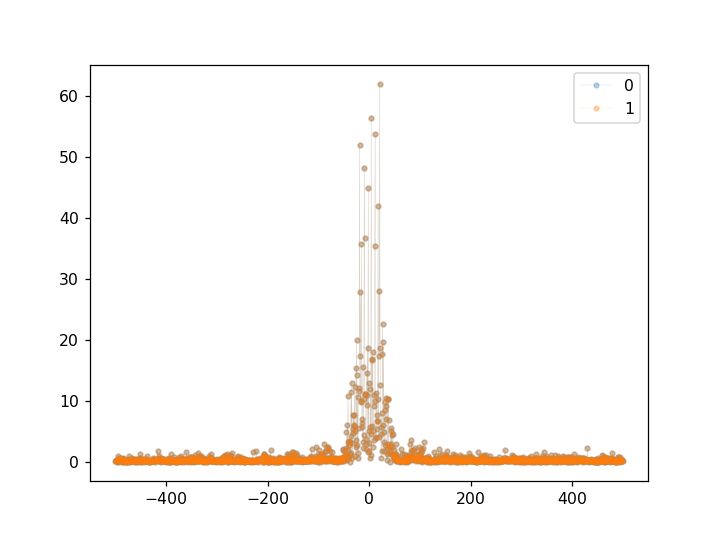

'\n'

In [8]:
#3. The Conjugate Cyclic Periodogram (c_cp_0)
def c_cp_0(z_t, alpha_vec, freqs):
    """
    return df columns are alphas and rows are freqs
    """
    fft = lambda x: np.fft.fftshift(np.fft.fft(x))
    N = len(z_t) 
    ZZ_r = pd.DataFrame(np.transpose(np.outer(np.exp(-1j*np.pi*alpha_vec), z_t)))  
    ZZ_r = ZZ_r.transform(fft)
    
    df = pd.DataFrame(np.abs(ZZ_r*np.fliplr(ZZ_r))/N)
    df.index = freqs
    # df.columns = alpha_vec
    return df , alpha_vec

alpha_vec = np.asarray([0, 1])


df_CI_f, alpha_vec = c_cp_0(x, alpha_vec, freqs)

print(f"carrier_freq estimate: {freqs[np.argmax(df_CI_f[0])]}")

# Graph
plt.close("all")
(np.abs(df_CI_f)).plot.line(linewidth=0.2, marker = '.', alpha=0.3)
plt.show()

'''
'''

SCF estimate max peak: 19.53125


<IPython.core.display.Javascript object>


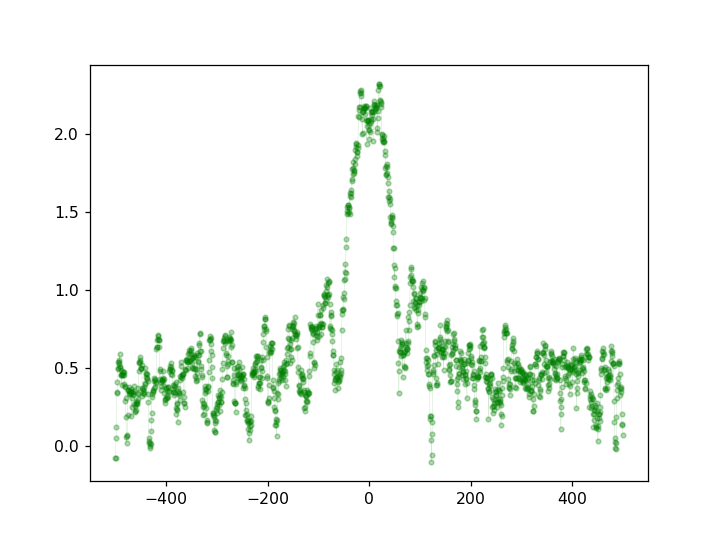

'\n'

In [9]:
# 4. The Frequency Smoothed Periodogram (fsp)
def fsp(z_t, N, Ts, Fs):
    """
    z_t is a complex valued discrete time signal.
    N (int) – Length of the filter in samples.
    Ts (float) – Symbol period in seconds.
    Fs (float) – Sampling Rate in Hz.
    """
    time_index, h_rect = rectfilter(N, Ts, Fs)
    I_f = p_0(z_t)
    return signal.fftconvolve(I_f, h_rect, "same")
    
N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10    # 1/dt             #(float) – Sampling Rate in Hz.

fs_I_f = fsp(x, N, Ts, Fs)


print(f"SCF estimate max peak: {freqs[np.argmax(fs_I_f)]}")
# Graph
plt.close("all")
plt.plot(freqs, np.log10(fs_I_f), linewidth=0.2, marker = '.', alpha=0.3, color="green")
plt.show()
'''
'''

In [74]:
# 5. The Frequency Smoothed Cyclic Periodogram (fscp)
def fscp(z_t, alpha_vec, N, Ts, Fs, freqs):
    f = lambda x, h=None: signal.fftconvolve(x, h, "same")
    
    time_index, h_rect = rectfilter(N, Ts, Fs)
    df_cp, alpha_vec = cp_0(z_t, alpha_vec, freqs)
    fcp = df_cp.transform(f, axis=1, h=h_rect)
    
    return fcp, alpha_vec

    
fpeaks = lambda x: freqs[find_peaks(x)[0]]

N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.

alpha_vec = np.linspace(0, 5)*(bit_rate/4)

df_fs_CI_f, alpha_vec = fscp(x, alpha_vec, N, Ts, Fs, freqs)


print(f"SCF estimate max peak: \n{ df_fs_CI_f.idxmax(axis=0, skipna=True).describe()} ")

# Graph
plt.close("all")
np.abs(df_fs_CI_f).plot.kde(linewidth=0.2, marker = '.', alpha=0.3)
plt.show()

'''
'''


(1536, 50, 480)
(1536, 50, 480)


TypeError: 'axes' is an invalid keyword to ufunc 'multiply'

<IPython.core.display.Javascript object>


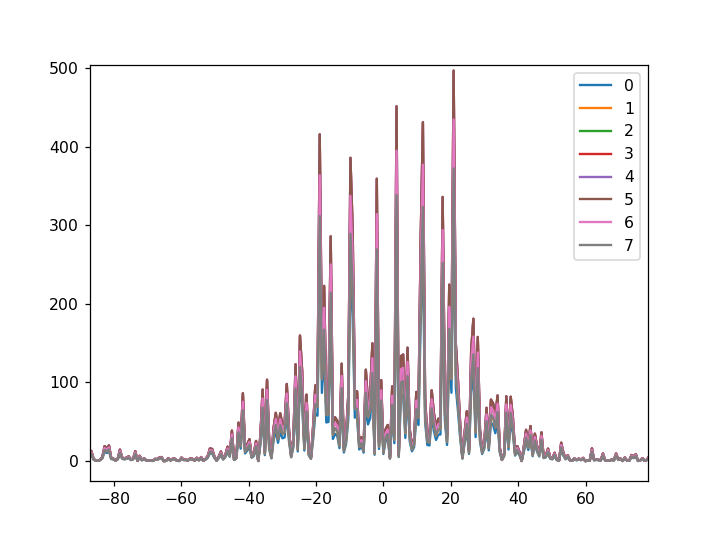

'\n'

In [84]:
# 6. The Frequency Smoothed Conjugate Cyclic Periodogram (c_fscp)
def c_fscp(z_t, alpha_vec, N, Ts, Fs, freqs):
    f = lambda x, h=None: signal.fftconvolve(x, h, "same")
    
    time_index, h_rect = rectfilter(N, Ts, Fs)
    df_cp, alpha_vec = c_cp_0(z_t, alpha_vec, freqs)
    
    fcp = df_cp.transform(f, axis=1, h=h_rect)
    
    return fcp, alpha_vec

# N controls bias of the alpha paramaters

N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.

alpha_vec = np.arange(5, 20, 2)

# print(alpha_vec)
df_fscp, alpha_vec = c_fscp(x, alpha_vec, N, Ts, Fs, freqs)



# Graph
plt.close("all")
np.abs(df_fscp).plot.line()
plt.show()
'''
'''


[-500.         -499.34895833 -498.69791667 ...  498.046875    498.69791667
  499.34895833]
SCF estimate max peak: 
count    1536.000000
mean      671.922526
std       242.544035
min         5.000000
25%       657.000000
50%       657.000000
75%       657.000000
max      1530.000000
dtype: float64 


<IPython.core.display.Javascript object>


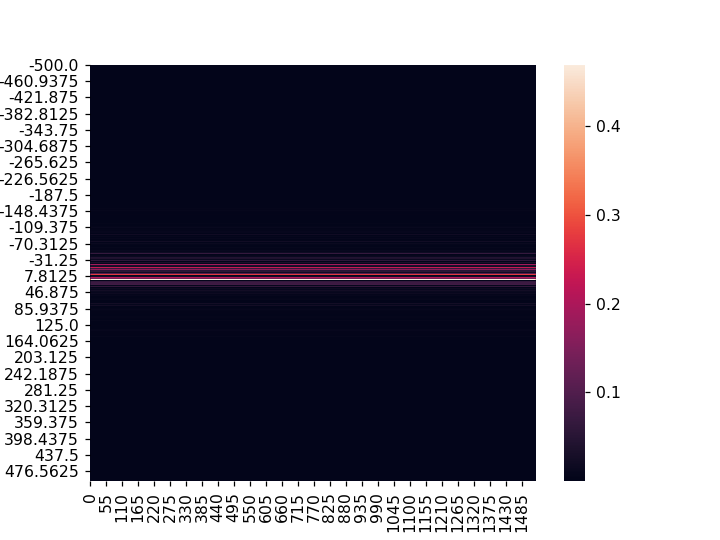

'\nplt.close("all")\nnp.log10(np.abs(df_SCF)).plot.line(linewidth=0.1, marker = \'.\', alpha=0.3)\nplt.show()\n'

In [215]:
# Test the alpha X freqs plots... 
# SCF .... 


N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =  1/dt             #(float) – Sampling Rate in Hz.

alpha_vec = freqs
print(alpha_vec)

df_SCF, alpha_vec = fscp(x, alpha_vec, N, Ts, Fs, freqs)

print(f"SCF estimate max peak: \n{df_SCF.idxmax(axis=1, skipna=True).describe()} ")



# Graph
plt.close("all")
sns.heatmap(np.abs(df_SCF))
plt.show()

"""
plt.close("all")
np.log10(np.abs(df_SCF)).plot.line(linewidth=0.1, marker = '.', alpha=0.3)
plt.show()
"""


C_SCF estimate max peak: 
count    1536.000000
mean       20.467448
std        13.040612
min         5.000000
25%         7.000000
50%        18.000000
75%        32.250000
max        45.000000
dtype: float64 


<IPython.core.display.Javascript object>


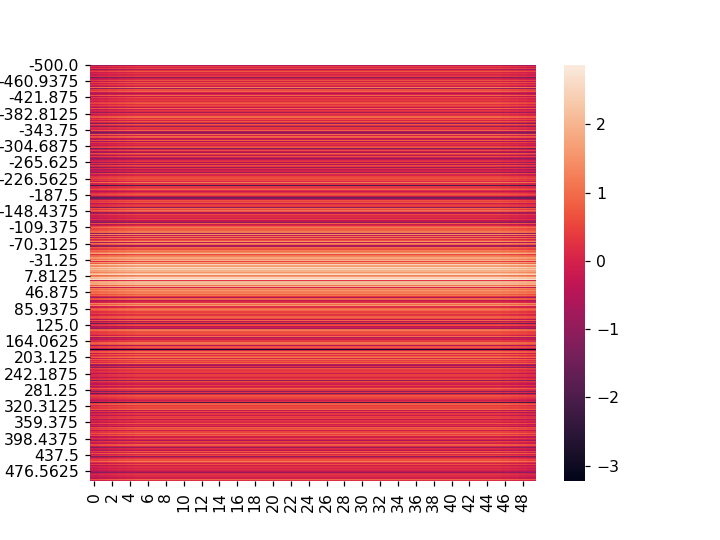

In [171]:
# Test the alpha X freqs plots... 


N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.

alpha_vec = np.linspace(0, 5)*(2+bit_rate/4)

df_C_SCF, alpha_vec = c_fscp(x, alpha_vec, N, Ts, Fs, freqs)

print(f"C_SCF estimate max peak: \n{ df_C_SCF.idxmax(axis=1, skipna=True).describe()} ")

# Graph
plt.close("all")
sns.heatmap(np.log10(np.abs(df_C_SCF)))
plt.show()
